In [4]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

csv_path = r"C:\Users\Aditya Koul\OneDrive\Desktop\CNN_beauty\dataset_info.csv"
df = pd.read_csv(csv_path, sep=';') 
print(" CSV loaded. Sample:")
print(df.head())


audio_base_path = r"C:\Users\Aditya Koul\OneDrive\Desktop\CNN_beauty\files"


emotions = ["euphoric", "joyfully", "sad", "surprised"]


X = []
y = []
missing = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    set_id = row["set_id"]
    folder_path = os.path.join(audio_base_path, set_id)

    if not os.path.exists(folder_path):
        missing.append(set_id)
        continue

    for emotion in emotions:
        file_path = os.path.join(folder_path, f"{emotion}.wav")
        if not os.path.isfile(file_path):
            missing.append(f"{set_id}/{emotion}.wav")
            continue

        try:
            audio, sr = librosa.load(file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfcc_scaled = np.mean(mfcc.T, axis=0)  # ✅ This compresses the time axis
            X.append(mfcc_scaled)
            y.append(emotion)
        except Exception as e:
            print(f" Error processing {file_path}: {e}")
            continue

print(f"\n Successfully extracted {len(X)} samples.")
print(f"Feature shape: {np.array(X).shape} | Labels shape: {np.array(y).shape}")


 CSV loaded. Sample:
   Unnamed: 0                                set_id  \
0           0  00026029e0--64991b6eef1fe70609d48edc   
1           1  00026029e0--64991b72e0daf97163c09c66   
2           2  00026029e0--64991b7fd94c0d5726dec353   
3           3  00026029e0--64991b907f82d9763944eba2   
4           4  00026029e0--64991bf2ffab6240f9f2418b   

                                                text  gender  age country  
0  The delicious aroma of freshly baked bread fil...    MALE   29      ZA  
1  I enjoy taking long walks in the peaceful coun...  FEMALE   42      NG  
2  The suspenseful novel kept me on the edge of m...  FEMALE   29      VN  
3  They celebrated their anniversary with a roman...  FEMALE   20      PK  
4  The diligent student earned top marks for her ...    MALE   30      PK  


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Aditya Koul\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]


 Successfully extracted 68 samples.
Feature shape: (68, 13) | Labels shape: (68,)


In [5]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_frames = 100  # You can tune this (based on max length in your dataset)
n_mfcc = 13

def pad_mfcc(mfcc, maxlen=max_frames):
    if mfcc.ndim != 2:
        print(" Warning: skipping malformed MFCC shape:", mfcc.shape)
        return np.zeros((n_mfcc, maxlen))
    if mfcc.shape[1] > maxlen:
        return mfcc[:, :maxlen]
    else:
        return np.pad(mfcc, ((0, 0), (0, maxlen - mfcc.shape[1])), mode='constant')


X_padded = np.array([pad_mfcc(mfcc) for mfcc in X])
X_padded = np.expand_dims(X_padded, axis=-1)         

# Step 2: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Step 4: CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(13, max_frames, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, callbacks=[early_stop])

# Step 6: Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Optional: Decode predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Epoch 1/30


C:\Users\Aditya Koul\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.2413 - loss: 1.3863 - val_accuracy: 0.2727 - val_loss: 1.3863
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3074 - loss: 1.3861 - val_accuracy: 0.2727 - val_loss: 1.3862
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3230 - loss: 1.3859 - val_accuracy: 0.2727 - val_loss: 1.3861
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2605 - loss: 1.3862 - val_accuracy: 0.2727 - val_loss: 1.3860
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3543 - loss: 1.3855 - val_accuracy: 0.2727 - val_loss: 1.3860
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2840 - loss: 1.3859 - val_accuracy: 0.2727 - val_loss: 1.3859
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2996 - loss: 1.3856 - val_accuracy: 0.2727 - val_loss: 1.3859
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3309 - loss: 1.3851 - val_accuracy: 0.2727 - val_loss: 1.3858
Epoch 9/30

C:\Users\Aditya Koul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aditya Koul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aditya Koul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
from tqdm import tqdm

X = []
y = []
ids = []  # NEW: store set_ids for later plotting

for _, row in tqdm(df.iterrows(), total=len(df)):
    set_id = row["set_id"]
    folder_path = os.path.join(audio_base_path, set_id)

    if not os.path.exists(folder_path):
        continue

    for emotion in emotions:
        file_path = os.path.join(folder_path, f"{emotion}.wav")
        if not os.path.isfile(file_path):
            continue

        try:
            audio, sr = librosa.load(file_path, sr=None)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc.T, axis=0)
            X.append(mfcc_mean)
            y.append(emotion)
            ids.append(set_id)  # Track valid set_id
        except:
            continue


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.97it/s]


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


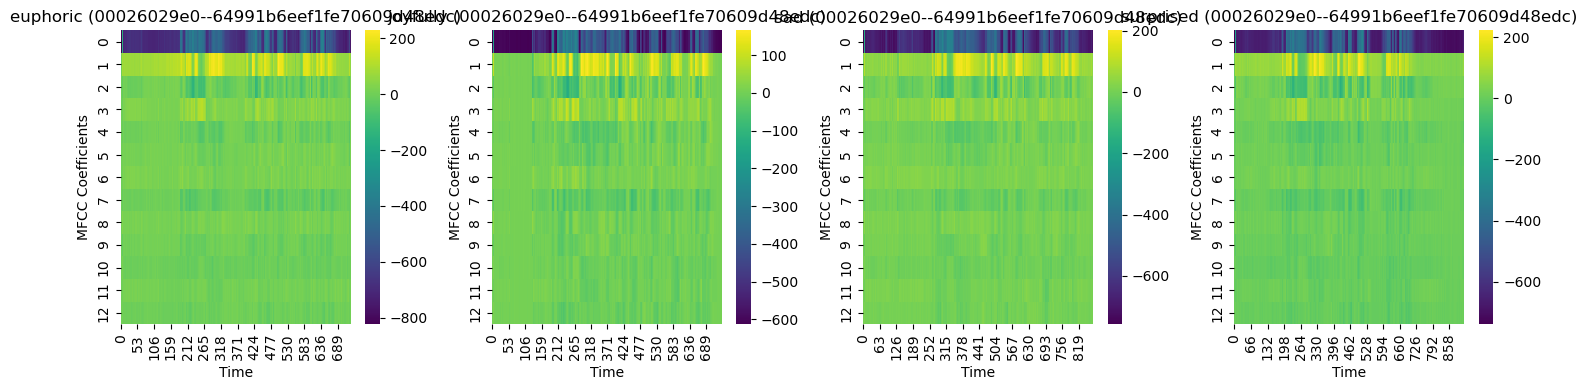

In [11]:
plt.figure(figsize=(15, 4))
for i in range(4):
    mfcc = librosa.feature.mfcc(y=librosa.load(os.path.join(audio_base_path, ids[i], f"{y[i]}.wav"), sr=None)[0], sr=sr, n_mfcc=13)
    plt.subplot(1, 4, i + 1)
    sns.heatmap(mfcc, cmap='viridis')
    plt.title(f"{y[i]} ({ids[i]})")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()


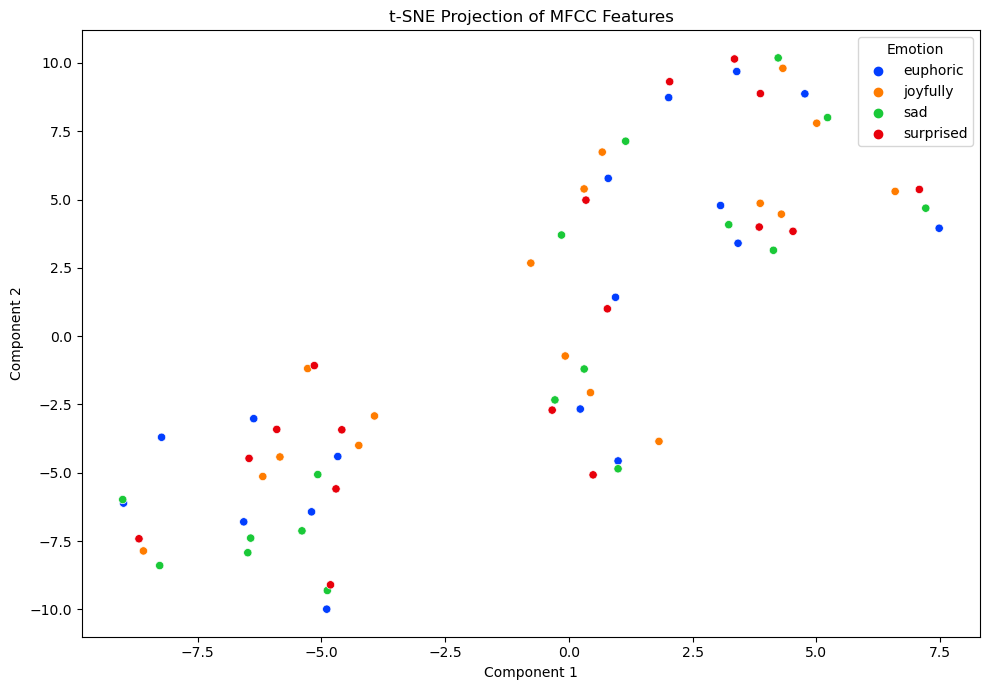

In [12]:
# Apply t-SNE on the compressed MFCCs
X_flat = np.array(X)  # Using the mean-compressed MFCCs
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
X_proj = tsne.fit_transform(X_flat)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_proj[:, 0], y=X_proj[:, 1], hue=y, palette='bright')
plt.title("t-SNE Projection of MFCC Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Emotion')
plt.tight_layout()
plt.show()


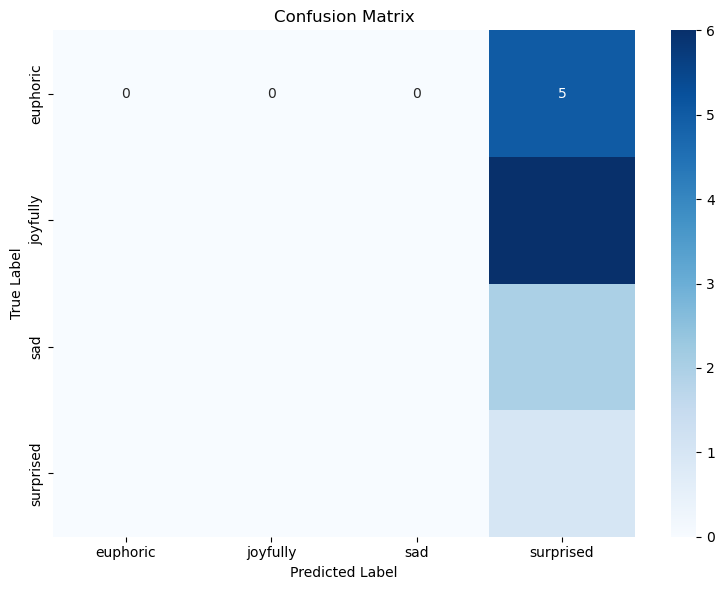

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
